In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from src.utils.graphs import saveDatasetBoxplot, saveQQPlot, saveMultiDistributionPDF, savePCACutOffThreshold
from src.utils.functions import mkdir_if_not_exists
from typing import List
from scipy.stats import kstest
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



In [2]:
overleaf_project_path = '/Users/paulovitorbarbosaramos/opt/Github/Overleaf/-Paulo-Vitor-Barbosa-Ramos---Disserta-o---UFJF---Consumo-de-energia-T-tulo-provis-rio/MonografiaModelo_v3/figs/'
mkdir_if_not_exists(f'{overleaf_project_path}/statistical/')
mkdir_if_not_exists(f'{overleaf_project_path}/statistical/QQPlots')
mkdir_if_not_exists(f'{overleaf_project_path}/statistical/autocorrelation')
mkdir_if_not_exists(f'{overleaf_project_path}/statistical/PCA')



In [3]:
firstReading = ['2012-06-01',
'2016-06-09',
'2015-01-27',
'2015-01-30',
'2015-01-30',
'2015-01-30',
'2015-01-30',
'2015-02-21',
'2015-05-01',
'2015-02-21',
'2015-02-21',
'2015-02-21',
'2015-02-21',
'2015-02-21',
'2015-09-29',
'2017-11-01',
'2016-06-01',
'2015-03-16',
'2015-03-26',
'2015-08-21',
'2017-11-01',
'2016-06-29',
'2017-07-27',
'2017-05-13',
'2017-05-15',
'2019-11-29',
'2019-03-06',
'2018-08-01']
lastReading = ['2015-10-03',
'2019-11-20',
'2018-01-29',
'2018-01-29',
'2018-01-29',
'2018-01-29',
'2018-01-29',
'2018-02-20',
'2018-02-21',
'2018-02-20',
'2018-02-20',
'2018-02-20',
'2018-02-20',
'2018-02-20',
'2018-02-20',
'2019-02-18',
'2017-04-29',
'2018-03-15',
'2018-03-25',
'2018-04-20',
'2018-06-04',
'2018-06-05',
'2020-04-05',
'2020-05-12',
'2020-05-14',
'2020-05-20',
'2020-05-20',
'2020-05-19']
Cover=[1.000,
0.994,
0.987,
0.995,
0.995,
0.997,
0.997,
0.987,
0.996,
0.995,
0.990,
0.992,
0.998,
0.995,
0.995,
0.881,
0.996,
0.986,
0.993,
0.998,
0.989,
0.996,
0.985,
0.998,
0.994,
0.997,
0.997,
0.998]
houseType= ['bungalow',
'duplex',
'modern',
'character',
'modern',
'apartment',
'character',
'special',
'special',
'duplex',
'apartment',
'special',
'modern',
'bungalow',
'apartment',
'apartment',
'bungalow',
'special',
'character',
'laneway',
'apartment',
'apartment',
'modern',
'character',
'apartment',
'apartment',
'special', 'bungalow']
hue_data_df = pd.DataFrame({'House': range(1, 29), 'firstReading': firstReading, 'lastReading': lastReading, 'cover': Cover, 'houseType': houseType})

In [4]:
hue_house_types = hue_data_df['houseType'].value_counts()

In [5]:
_id_df = pd.read_csv('data/Pecanstreet/participants_data/15min/15minute_data_austin.csv')
real_participant_ids = list(_id_df['dataid'].unique())
data_columns = _id_df.columns.to_list()

In [6]:
meta_df = pd.read_csv('data/Pecanstreet/metadata.csv')
meta_df.loc[meta_df['building_type']=='Single-Family Home 001 (Master)','building_type']='Single-Family Home'
meta_data_df = meta_df.copy()
house_types = meta_data_df[meta_data_df['active_record'] == 'yes']['building_type'].value_counts()

In [7]:
house_types

Single-Family Home    1136
Town Home               24
Apartment                9
Sales                    2
Mobile Home              1
Name: building_type, dtype: int64

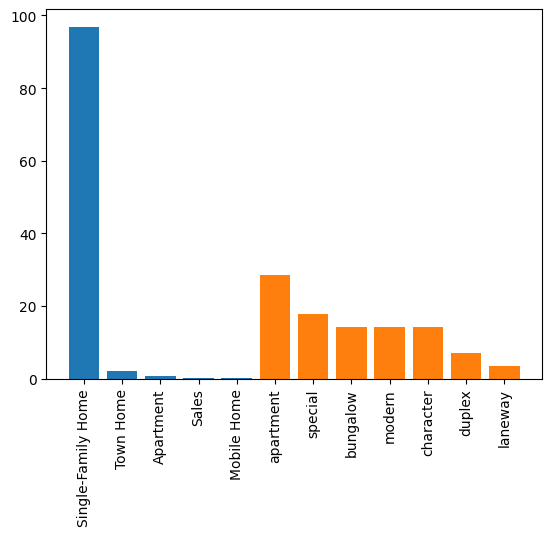

In [8]:
plt.bar(house_types.index, (house_types.values/house_types.values.sum() * 100))
plt.bar(hue_house_types.index, (hue_house_types.values/hue_house_types.values.sum() * 100))
plt.xticks(rotation=90)
plt.show()

In [9]:
meta_df.drop(axis=0, index=0, inplace=True)

In [10]:
meta_df['dataid'] = meta_df['dataid'].astype(int)

In [11]:
meta_df = meta_df[(meta_df['active_record'] == 'yes') & (meta_df['dataid'].isin(real_participant_ids))]

In [12]:
meta_df['building_type'].value_counts()

Single-Family Home    21
Name: building_type, dtype: int64

In [13]:
default_columns = [item for item in data_columns if item in meta_df.columns.to_list()]

In [14]:
present_values = meta_df[default_columns]
_id_values = present_values[present_values['dataid'] == 661].count()

In [15]:
present_values

,dataid,air1,air2,air3,airwindowunit1,aquarium1,bathroom1,bathroom2,bedroom1,bedroom2,...,solar,solar2,sprinkler1,sumppump1,utilityroom1,venthood1,waterheater1,waterheater2,wellpump1,winecooler1
47,661,yes,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,...,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,1642,yes,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,...,yes,NaN,NaN,NaN,yes,yes,NaN,NaN,NaN,NaN
58,2335,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,yes,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN
64,2818,yes,NaN,NaN,NaN,NaN,yes,NaN,yes,NaN,...,yes,NaN,yes,NaN,NaN,yes,NaN,NaN,NaN,NaN
68,3039,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,yes,NaN,NaN,NaN,NaN,NaN,yes,yes,yes,NaN
69,3456,yes,NaN,NaN,NaN,NaN,yes,NaN,yes,NaN,...,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,4031,yes,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,...,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,4767,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,7536,yes,NaN,NaN,NaN,NaN,NaN,NaN,yes,yes,...,yes,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN
137,7951,yes,yes,NaN,NaN,NaN,yes,yes,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN


In [16]:
filled = np.count_nonzero(_id_values.values) - 1
nonfilled = len(_id_values.values) - filled - 1
print('filled:', filled)
print('non-filled:', nonfilled)
print(len(_id_values.values))

filled: 14
non-filled: 61
76


In [17]:
def createDataDict(dataset: str, _id: str, data_type: str, resolutions: List[str]):
    return {
            resolution: 
                        {'scaler': MinMaxScaler(feature_range=(-1,1)), 
                         'df': pd.read_csv(f'data/{dataset}/participants_data/{resolution}/features/{data_type}/{_id}.csv')} for resolution in resolutions}

In [18]:
pecan_dict = createDataDict(dataset='Pecanstreet', 
                            _id='661_features', 
                            data_type='all', 
                            resolutions=['1min', '15min', '1hour'])

In [19]:
hue_dict = createDataDict(dataset='HUE',
                         _id='residential_1',
                         data_type='all',
                         resolutions=['1hour'])

In [20]:
mkdir_if_not_exists('etc/imgs/Pecanstreet/statistical-study')
mkdir_if_not_exists('etc/imgs/HUE/statistical-study')
PCA_data = []

In [21]:
pca_style = {
    'Pecanstreet': {
        '1min':{
            'line-style': '-',
            'marker': 'o',
            'color': 'b',
        },
        '15min':{
            'line-style': '-',
            'marker': 'o',
            'color': 'g',
        },
        '1hour':{
            'line-style': '-',
            'marker': 'o',
            'color': 'c',
        }
    },
    'HUE': {
        '1hour': {
            'line-style': '--',
            'marker': 's',
            'color': 'k'
        }
        
    }

}

In [22]:
def makePCACumSum(data):
    data.dropna(inplace=True)
    pca = PCA(n_components = 0.99)
    features_pca = pca.fit(data)
    return np.cumsum(pca.explained_variance_ratio_), pca.transform(data)


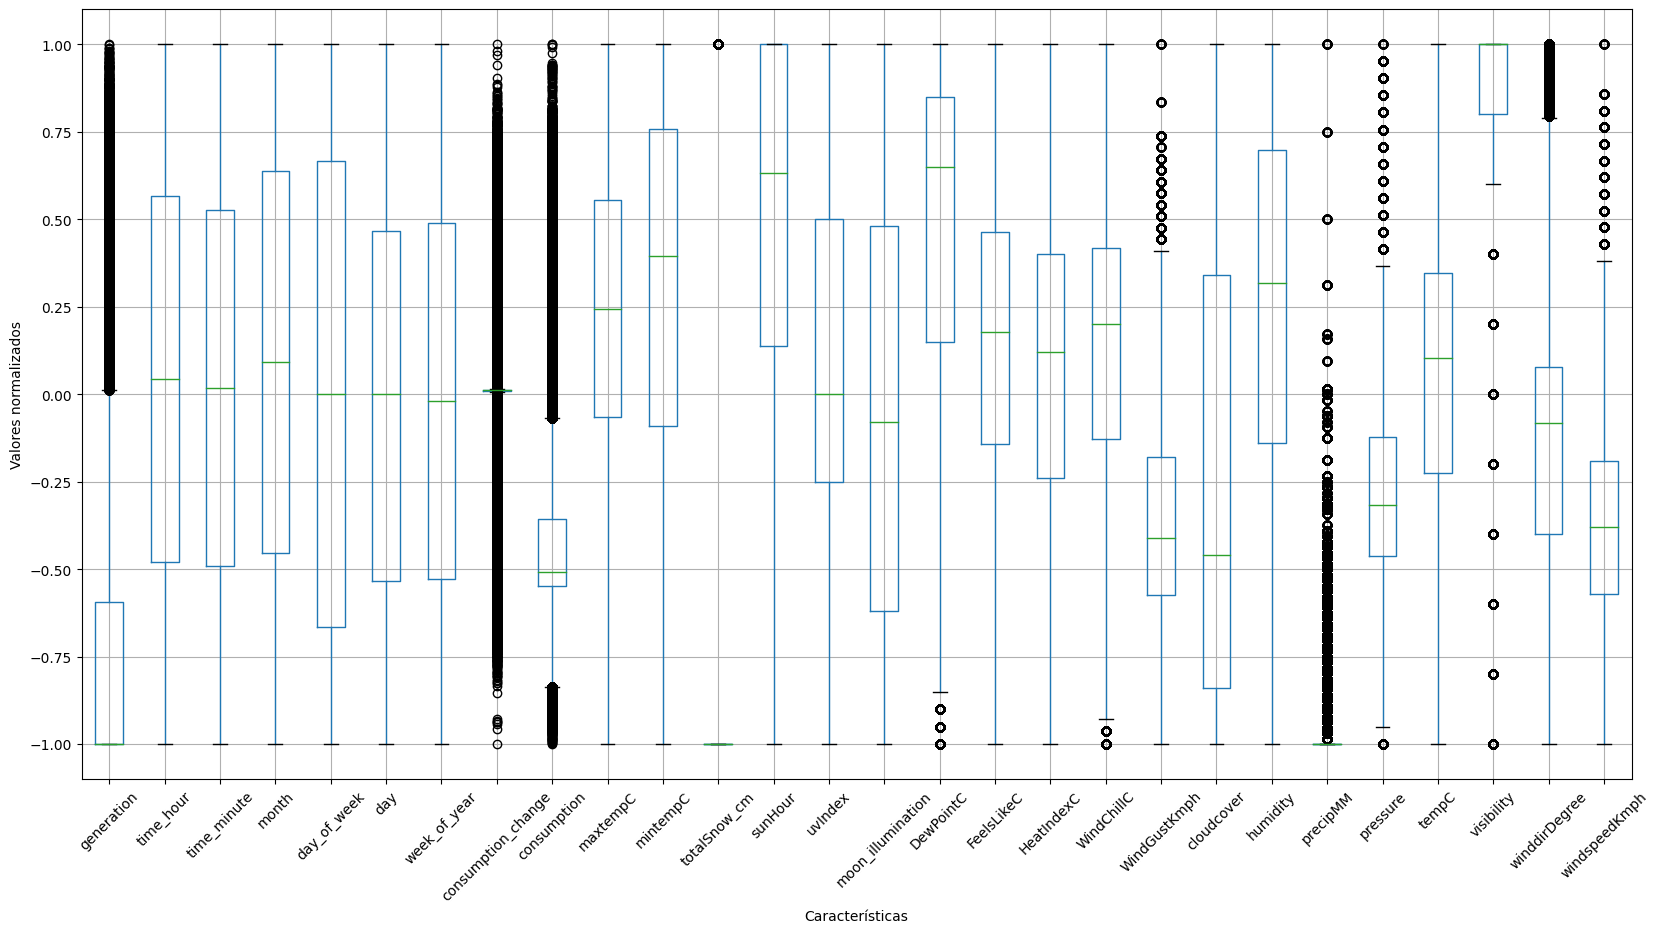

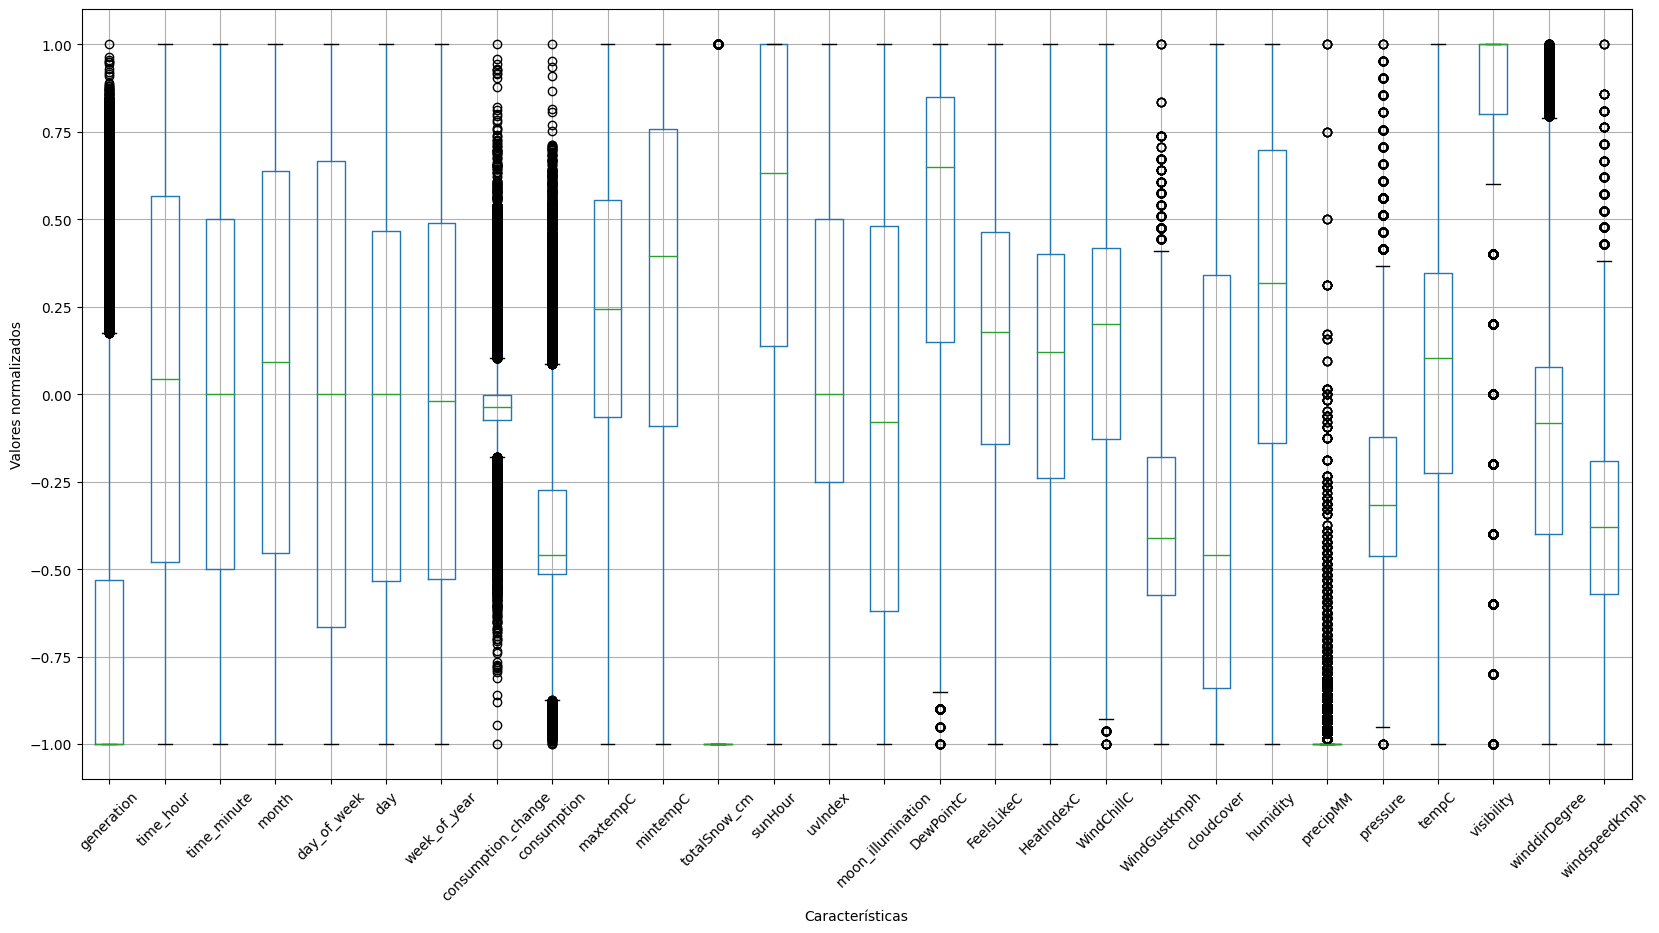

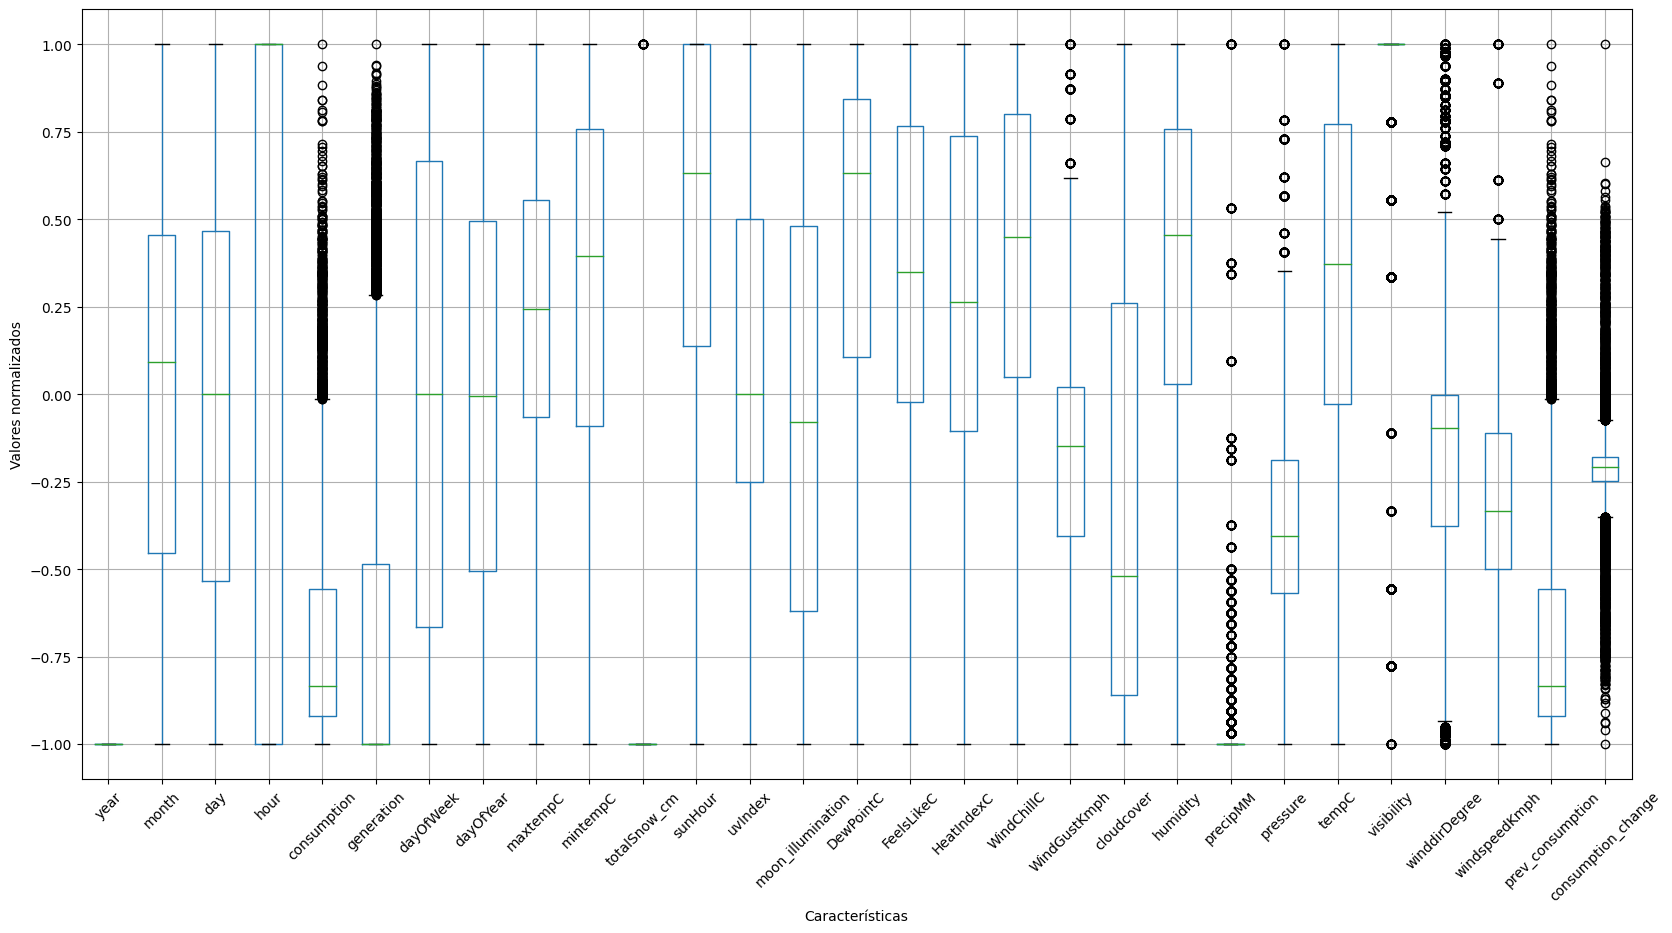

In [23]:
for resolution in pecan_dict.keys():
    scaler = pecan_dict[resolution]['scaler']
    df = pecan_dict[resolution]['df']
    pecan_dict[resolution]['scaler'] = scaler.fit(df)
    pecan_dict[resolution]['df'] = pd.DataFrame(data=scaler.transform(df),
                                       index=df.index, columns=df.columns)
    
    pca_cumulative, transform_data = makePCACumSum(pecan_dict[resolution]['df'])

    
    PCA_data.append((pca_cumulative, 
                     pca_style['Pecanstreet'][resolution]['marker'],
                     pca_style['Pecanstreet'][resolution]['line-style'],
                     pca_style['Pecanstreet'][resolution]['color'],
                     f'Pecanstreet - {resolution}'
                    ))
    saveDatasetBoxplot(df=pecan_dict[resolution]['df'], 
                       path=f'{overleaf_project_path}/statistical', 
                       filename=f"Pecanstreet-{resolution}_all_boxplot_df")
    plt.show()
    

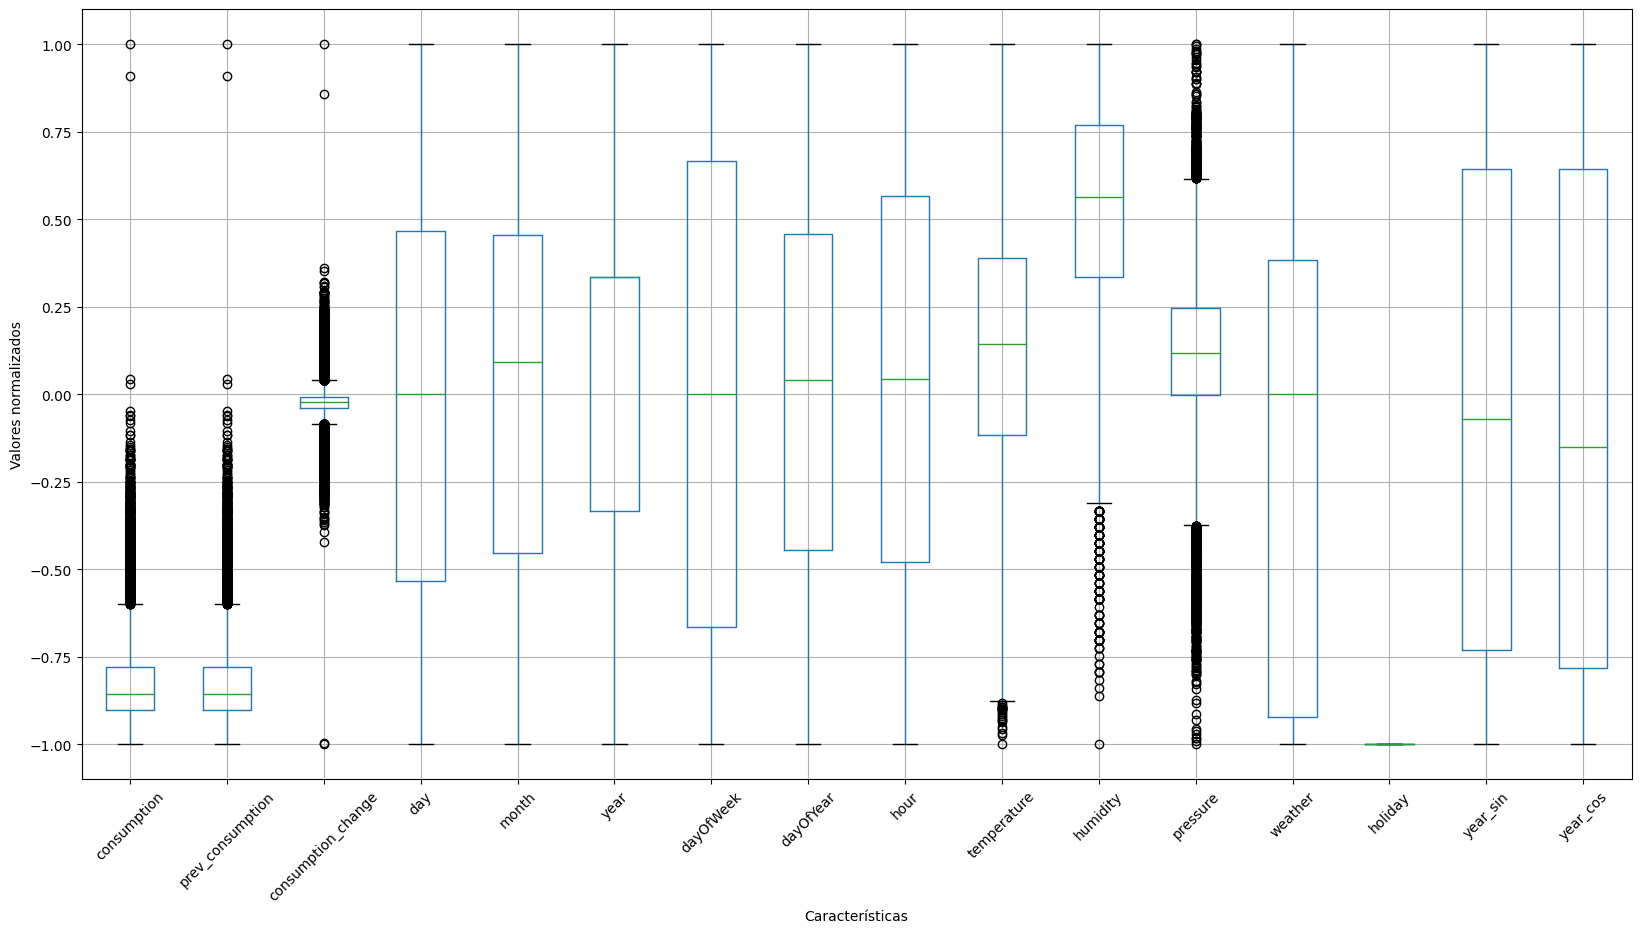

In [25]:
for resolution in hue_dict.keys():
    scaler = hue_dict[resolution]['scaler']
    df = hue_dict[resolution]['df']
    hue_dict[resolution]['scaler'] = scaler.fit(df)
    hue_dict[resolution]['df'] = pd.DataFrame(data=scaler.transform(df),
                                       index=df.index, columns=df.columns)
    
    pca_cumulative, transform_data = makePCACumSum(hue_dict[resolution]['df'])


    PCA_data.append((pca_cumulative, 
                     pca_style['HUE'][resolution]['marker'],
                     pca_style['HUE'][resolution]['line-style'],
                     pca_style['HUE'][resolution]['color'],
                     f'HUE - {resolution}'
                    ))

    saveDatasetBoxplot(df=hue_dict[resolution]['df'], 
                       path=f'{overleaf_project_path}/statistical', 
                       filename=f"HUE-{resolution}_all_boxplot_df")
    plt.show()


'[*] - PCA cut-off thresholst saved on /Users/paulovitorbarbosaramos/opt/Github/Overleaf/-Paulo-Vitor-Barbosa-Ramos---Disserta-o---UFJF---Consumo-de-energia-T-tulo-provis-rio/MonografiaModelo_v3/figs//statistical/PCA/limite_confianca_comparacao'

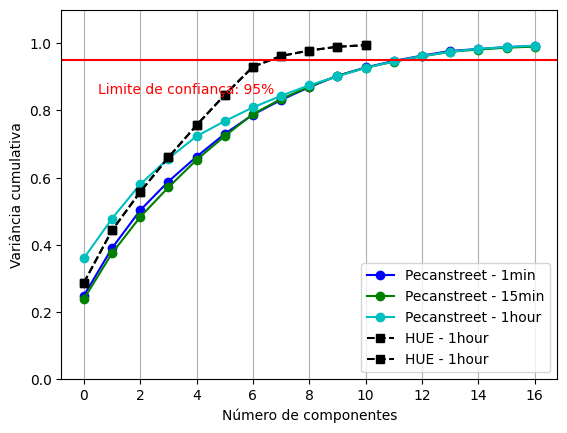

In [26]:
savePCACutOffThreshold(PCA_data, f'{overleaf_project_path}/statistical/PCA', 'limite_confianca_comparacao', None)

In [27]:
df = pd.DataFrame({
                'Pecanstreet - 1min': pecan_dict['1min']['df']['consumption'],
                'Pecanstreet - 15min': pecan_dict['15min']['df']['consumption'],
                'Pecanstreet - 1hour': pecan_dict['1hour']['df']['consumption'],
                'HUE - 1hour': hue_dict['1hour']['df']['consumption'],
})

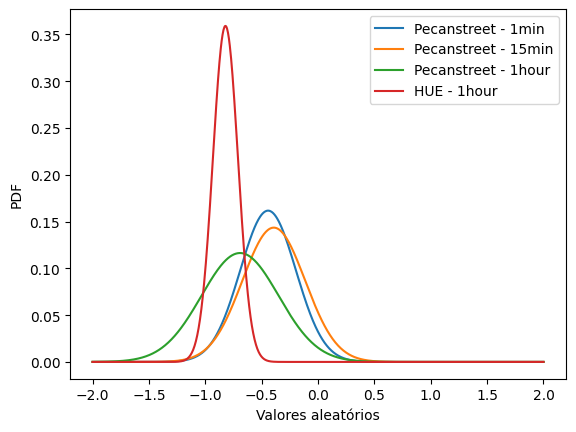

In [28]:
df_data = [(df[column].dropna(), column) for column in df.columns]
saveMultiDistributionPDF(data = df_data, path=f'{overleaf_project_path}/statistical', filename='pdf_study')
plt.show()

********* Valor estatístico de Kolmogorov-Smirnov ************ 0.4521948361378121
********* p-value ************* 0.0 H_o rejeitada: estacionária


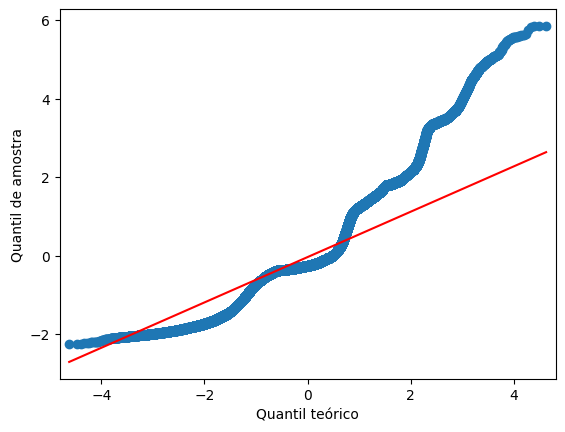

********* Valor estatístico de Kolmogorov-Smirnov ************ 0.39125984624461063
********* p-value ************* 0.0 H_o rejeitada: estacionária


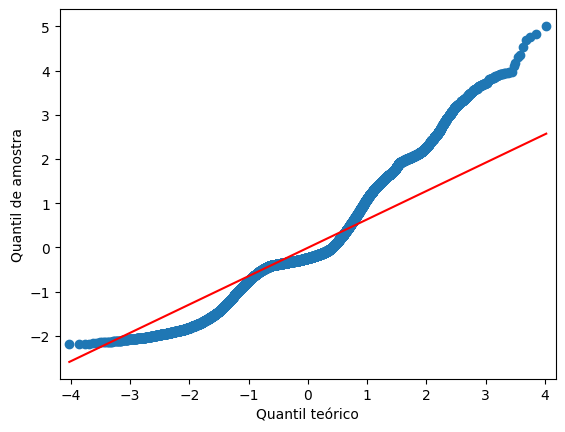

********* Valor estatístico de Kolmogorov-Smirnov ************ 0.4750295879765636
********* p-value ************* 0.0 H_o rejeitada: estacionária


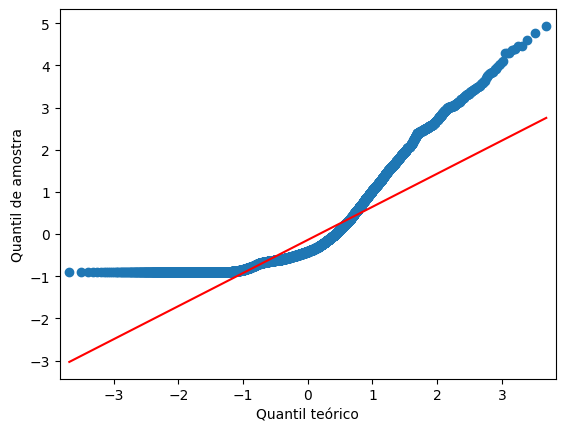

********* Valor estatístico de Kolmogorov-Smirnov ************ 0.6768190365193185
********* p-value ************* 0.0 H_o rejeitada: estacionária


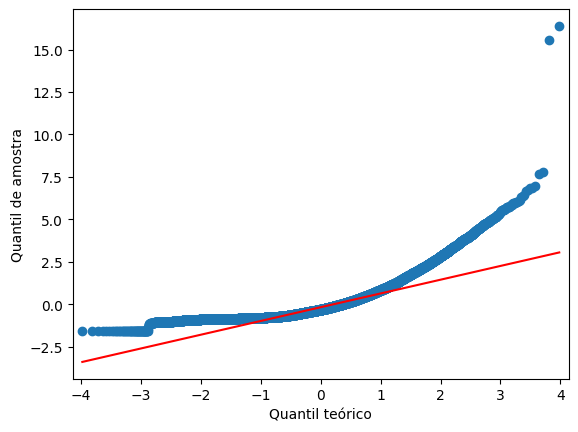

In [31]:
for column in df.columns:
    data = df[column].dropna()
    ks_statistic, p_value = kstest(data, 'norm')

    print("********* Valor estatístico de Kolmogorov-Smirnov ************", ks_statistic)
    print("********* p-value *************", p_value, "H_o rejeitada: estacionária" if p_value < 0.05 else "não estacionária")
    
    saveQQPlot(data=data, path=f'{overleaf_project_path}/statistical/QQPlots/', filename=f"qq_plot_{column}")
    plt.show()


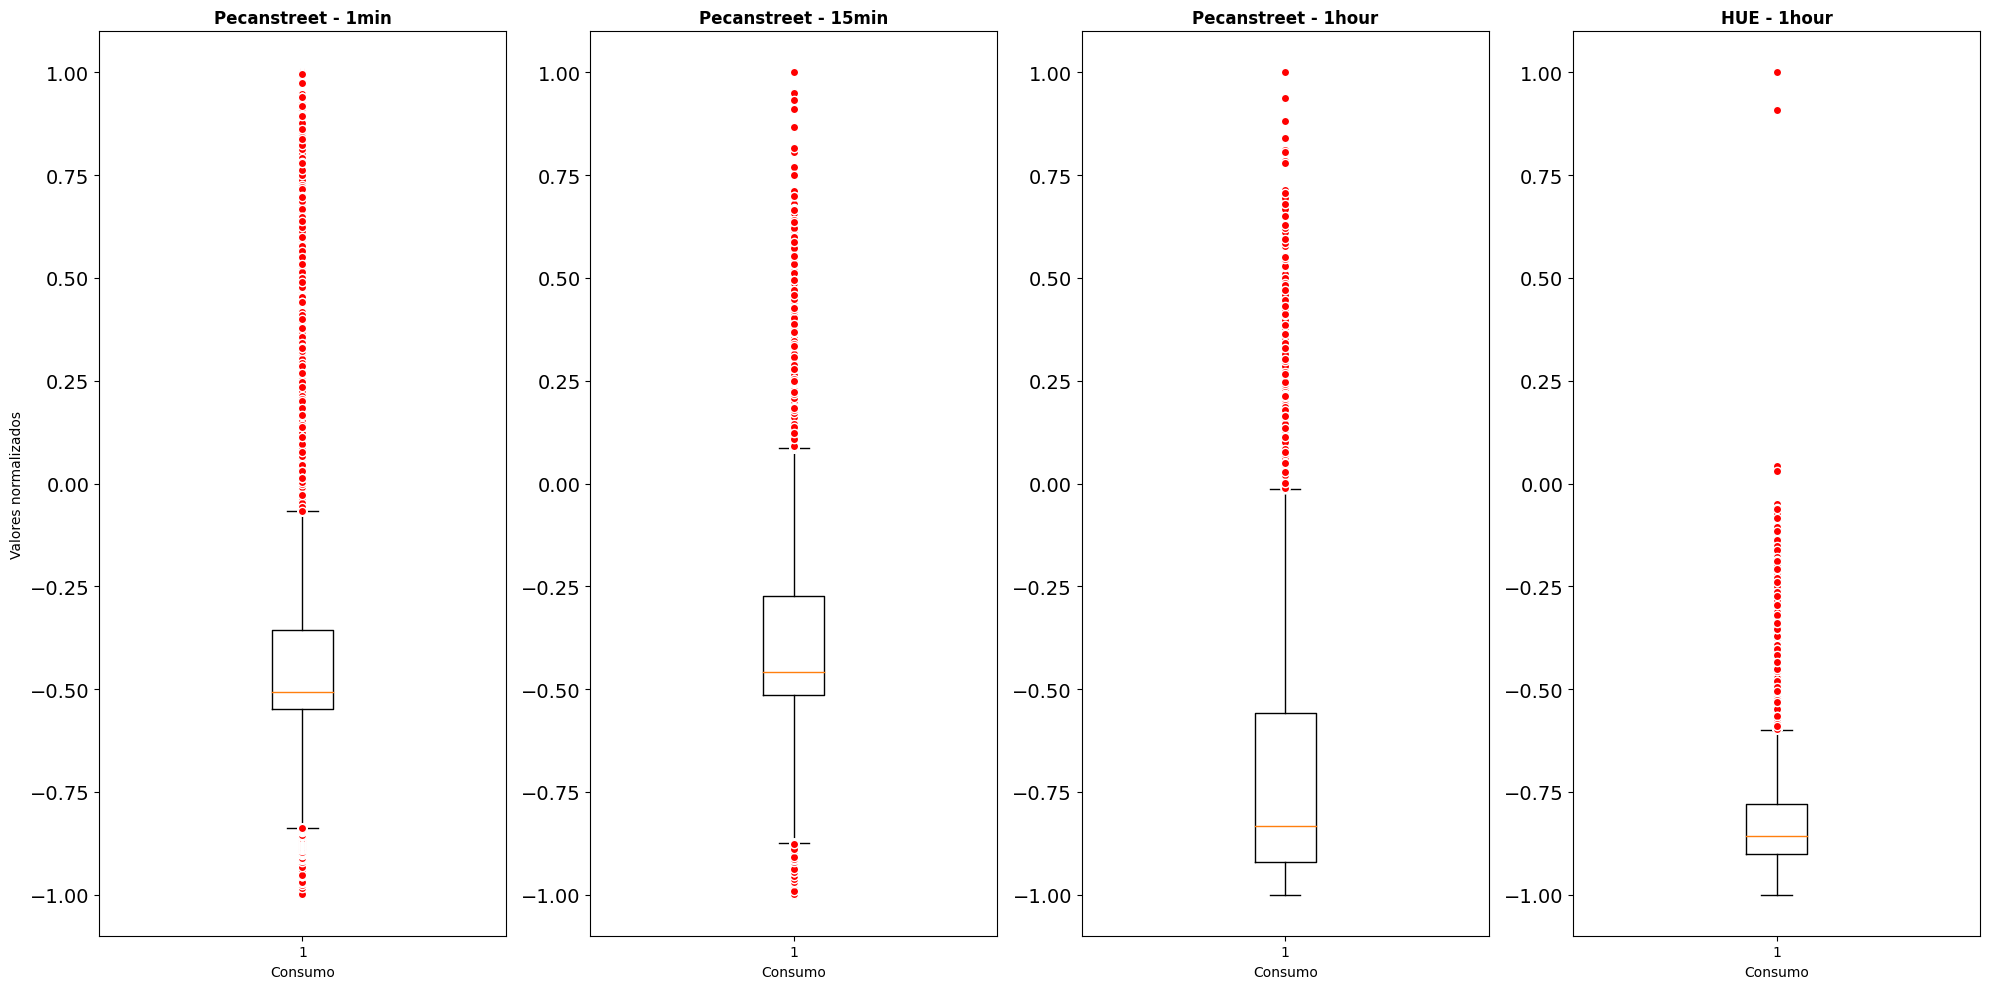

In [32]:
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
fig, axs = plt.subplots(1, len(df.columns), figsize=(20,10))

for i, ax in enumerate(axs.flat):
    data = df.iloc[:,i]
    data.dropna(inplace=True)
    ax.boxplot(data, flierprops=red_circle)
    df.iloc[:,i]
    ax.set_title(df.columns[i], fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xlabel('Consumo')

axs[0].set_ylabel('Valores normalizados')
plt.savefig(f'{overleaf_project_path}/statistical/boxplot_dataset_consumption_comparison.pdf', dpi=200, bbox_inches='tight')
plt.tight_layout()

In [33]:
df.shape

(525530, 4)

In [34]:
data = next(iter(enumerate(df)))
df[data[1]].values

array([-0.51074841, -0.51090764, -0.51098726, ..., -0.42754777,
       -0.4258758 , -0.39808917])

In [35]:
df['Pecanstreet - 1min']

0        -0.510748
1        -0.510908
2        -0.510987
3        -0.510987
4        -0.511067
            ...   
525525   -0.426115
525526   -0.427468
525527   -0.427548
525528   -0.425876
525529   -0.398089
Name: Pecanstreet - 1min, Length: 525530, dtype: float64

In [36]:
for _, dataset in enumerate(df):
    print(dataset)
    data = df[dataset].dropna()
    print('ACF:', np.round(acf(data), 2))
    print('PACF:', np.round(pacf(data), 2))
    print('***********************')

Pecanstreet - 1min
ACF: [1.   0.96 0.94 0.91 0.88 0.86 0.83 0.81 0.78 0.77 0.75 0.73 0.72 0.7
 0.69 0.68 0.68 0.68 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67
 0.67 0.66 0.66 0.66 0.66 0.66 0.66 0.66 0.66 0.65 0.65 0.65 0.65 0.65
 0.64 0.64 0.64 0.63 0.63 0.62 0.62 0.62 0.61 0.61 0.6  0.6  0.59 0.59
 0.58 0.58]
PACF: [ 1.    0.96  0.29 -0.23  0.05  0.04 -0.05  0.07 -0.02  0.03  0.03  0.03
  0.04  0.01  0.04  0.04  0.05  0.04  0.02  0.05  0.02  0.03  0.02  0.01
  0.02  0.01  0.02  0.02  0.01  0.02  0.01  0.03  0.01  0.02  0.02  0.02
  0.01  0.01  0.01  0.    0.    0.01  0.    0.01  0.   -0.    0.   -0.
  0.   -0.01  0.   -0.    0.   -0.01  0.01  0.    0.01  0.  ]
***********************
Pecanstreet - 15min
ACF: [ 1.    0.82  0.76  0.73  0.67  0.63  0.59  0.56  0.52  0.49  0.46  0.43
  0.4   0.37  0.34  0.32  0.29  0.27  0.24  0.22  0.2   0.18  0.16  0.15
  0.13  0.11  0.1   0.08  0.07  0.06  0.04  0.03  0.02  0.01  0.01  0.01
  0.    0.    0.    0.    0.   -0.    0.   -0.   -0.01 

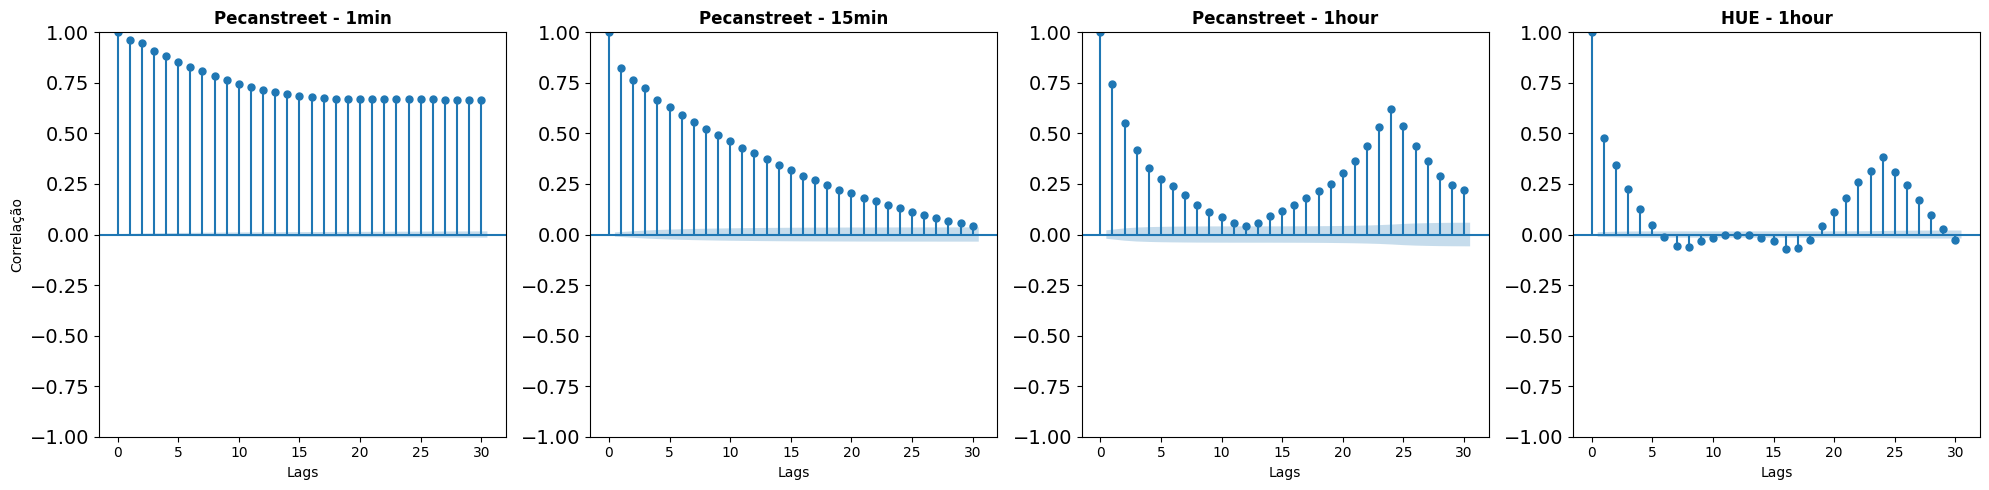

In [40]:
f, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
for i,ax in enumerate(axs.flat):
    data = df.iloc[:,i]
    data.dropna(inplace=True)
    plot_acf(data,lags=30, ax=ax, title='Autocorrelação')
    df.iloc[:,i]
    ax.set_title(df.columns[i], fontweight='bold')
    ax.set_xlabel('Lags')
    ax.tick_params(axis='y', labelsize=14)
axs[0].set_ylabel('Correlação')
plt.savefig(f'{overleaf_project_path}/statistical/autocorrelation/datasets_acf.pdf', dpi=200, bbox_inches='tight')
plt.tight_layout()


In [ ]:
f, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
for i,ax in enumerate(axs.flat):
    data = df.iloc[:,i]
    data.dropna(inplace=True)
    plot_pacf(data,lags=30, ax=ax, method='ols', title='Autocorrelação Parcial')
    df.iloc[:,i]
    ax.set_title(df.columns[i], fontweight='bold')
    ax.set_xlabel('Lags')
    ax.tick_params(axis='y', labelsize=14)
axs[0].set_ylabel('Correlação')
plt.savefig(f'{overleaf_project_path}/statistical/autocorrelation/datasets_pacf.pdf', dpi=200, bbox_inches='tight')
plt.tight_layout()
